In [333]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [334]:
trips_df = pd.read_pickle('../00_data/trips_hourly_selected.pkl')

In [335]:
demand = trips_df['starting_trips']
demand.head(2)

index
2019-01-01 01:00:00     8.0
2019-01-01 02:00:00    11.0
Name: starting_trips, dtype: float64

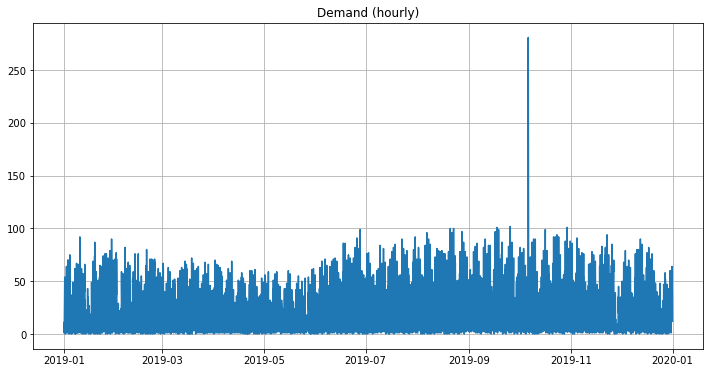

In [336]:
plt.figure(figsize=(12, 6))
plt.plot(demand)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

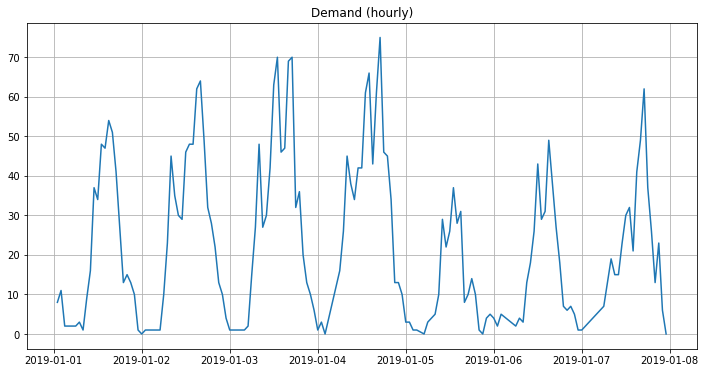

In [337]:
demand_first_week = demand[demand.index < '2019-01-8']
plt.figure(figsize=(12, 6))
plt.plot(demand_first_week)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

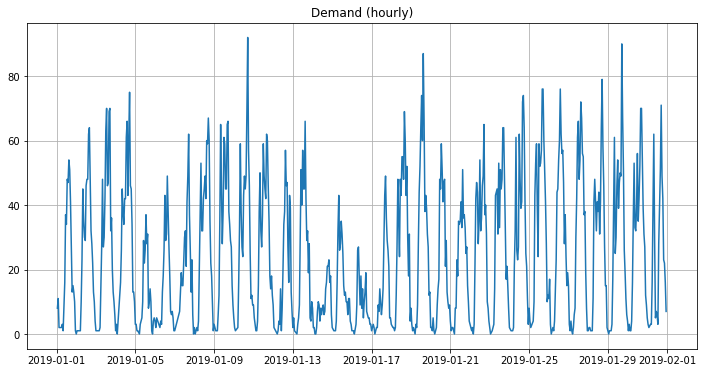

In [338]:
demand_january = demand[demand.index.month == 1]
# demand_january = demand[demand.index.isocalendar().week == 2]
plt.figure(figsize=(12, 6))
plt.plot(demand_january)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

In [339]:
demand = demand_january

In [340]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [341]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test

    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Dickey-Fuller: p={0:.5f}".format(p_value))

        upper_bound = 1.96 / np.sqrt(len(y))
        lower_bound = -1.96 / np.sqrt(len(y))

        lag_acf = smt.acf(y, nlags=lags)
        acf_ax.plot(lag_acf, label="Autocorrelation")
        acf_ax.axhline(y=0, linestyle="--", color="gray")
        acf_ax.axhline(y=lower_bound, linestyle="--", color="gray")
        acf_ax.axhline(y=upper_bound, linestyle="--", color="gray")
        acf_ax.set_title("ACF")

        lag_pacf = smt.pacf(y, nlags=lags, method="ols")
        pacf_ax.plot(lag_pacf, label="Partial Autocorrelation")
        pacf_ax.axhline(y=0, linestyle="--", color="gray")
        pacf_ax.axhline(y=lower_bound, linestyle="--", color="gray")
        pacf_ax.axhline(y=upper_bound, linestyle="--", color="gray")
        pacf_ax.set_title("PACF")

        acf_lag_value_crossing_upper_bound = np.argmax(lag_acf < upper_bound)
        pacf_lag_value_crossing_upper_bound = np.argmax(lag_pacf < upper_bound)
        print("ACF lag value crossing upper bound: {0}".format(acf_lag_value_crossing_upper_bound))
        print("PACF lag value crossing upper bound: {0}".format(pacf_lag_value_crossing_upper_bound))
        plt.tight_layout()


ACF lag value crossing upper bound: 6
PACF lag value crossing upper bound: 2


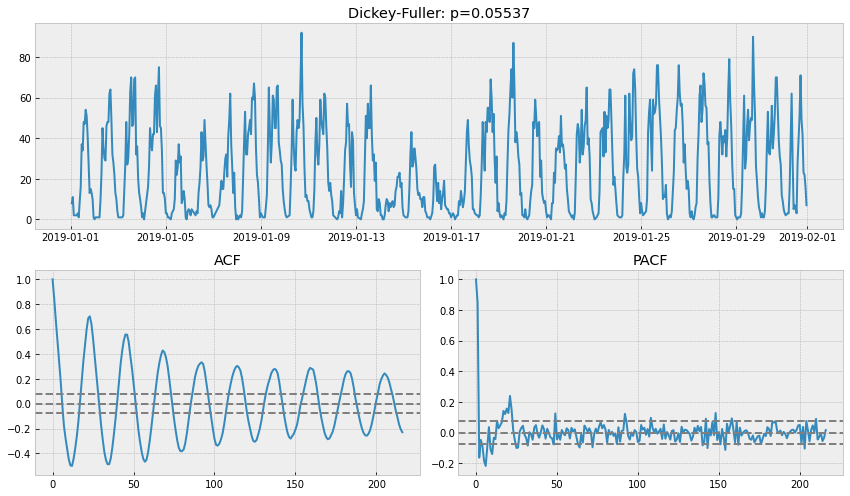

In [342]:
tsplot(demand, lags=24 * 9)

In [343]:
# the datetime index has to have a frequency for seasonal decomposition
demand = demand.asfreq('H', fill_value=0)

ACF lag value crossing upper bound: 7
PACF lag value crossing upper bound: 3


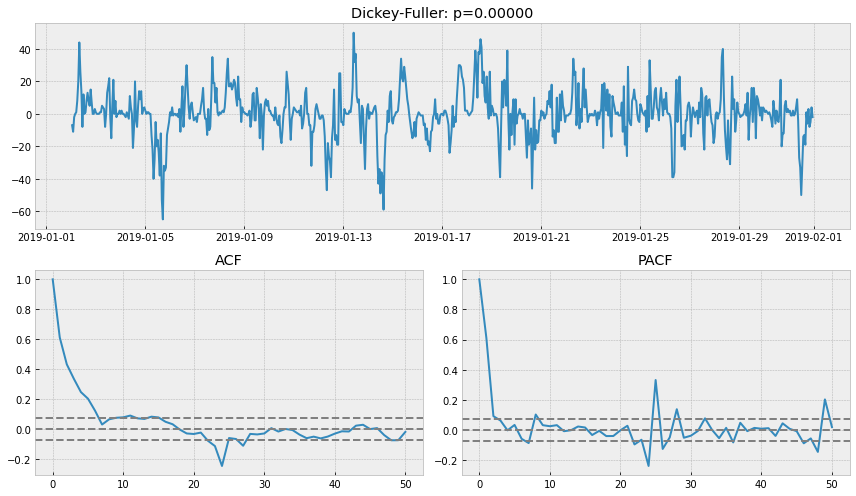

In [344]:
demand_diff_daily = demand - demand.shift(24)
demand_diff_daily = demand_diff_daily.dropna()
tsplot(demand_diff_daily, lags=50)

ACF lag value crossing upper bound: 1
PACF lag value crossing upper bound: 1


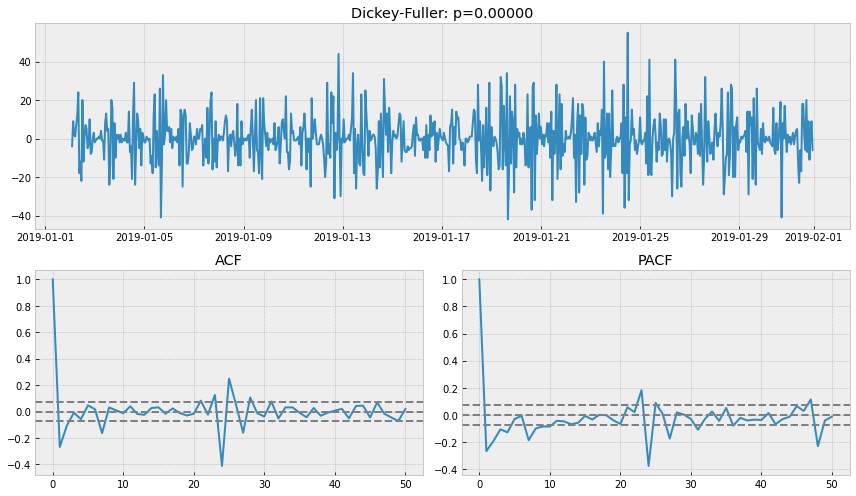

In [345]:
demand_diff = demand_diff_daily - demand_diff_daily.shift(1)
demand_diff = demand_diff.dropna()
tsplot(demand_diff, lags=50)

In [347]:
from statsmodels.tsa.arima.model import ARIMA

In [354]:
p = 1 # first value that crosses the upper bound in PACF
d = 1 # number of differencings applied
q = 1 # first value that crosses the upper bound in ACF

P = 2 # number of significant lags in PACF at seasonal intevals
D = 1 # number of seasonal differencing applied
Q = 1 # number of significant lags in ACF at seasonal intervals
s = 24 # season length

model = ARIMA(demand, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_ARMA = model.fit()

In [358]:
# import mse, mae
from sklearn.metrics import mean_squared_error, mean_absolute_error

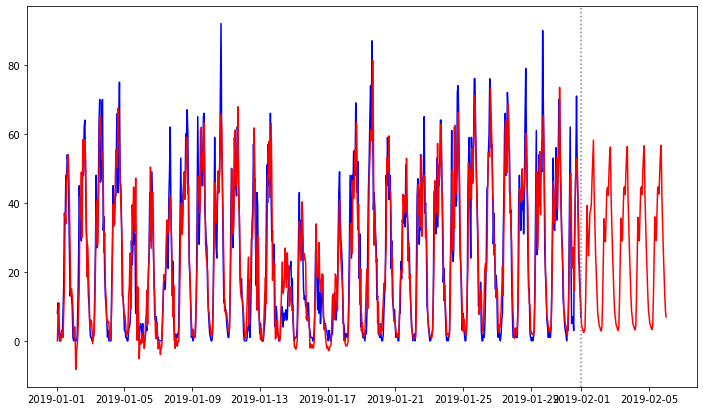

In [360]:
n_predicted_hours = 24 * 5
future_prediction = results_ARMA.predict(
    start=len(demand),
    end=len(demand) + n_predicted_hours,
    dynamic=False,
)

fig = plt.figure(figsize=(12, 7))

prediciton = pd.concat([results_ARMA.fittedvalues, future_prediction], axis=0)
plt.plot(demand, label="Original", color="blue")
plt.plot(prediciton, label="Predictions", color="red")
plt.axvline(x=demand.index[-1], color="gray", linestyle="dotted")

plt.show()


In [363]:
def mean_absolute_percentage_error(y_true, y_pred):
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [364]:

mse = mean_squared_error(demand, results_ARMA.fittedvalues)
mae = mean_absolute_error(demand, results_ARMA.fittedvalues)
mape = mean_absolute_percentage_error(demand, results_ARMA.fittedvalues)

print("MSE: {0}".format(mse))
print("MAE: {0}".format(mae))
print("MAPE: {0}".format(mape))

MSE: 84.55259654916729
MAE: 6.746047583613667
MAPE: inf
